# Energy Signature Analysis 

Energy Signature of buildings are simple scatter plots of outside-air-temperature (OAT) and energy consumption. They serve as footprint of the buildings thermal behaviour. This notebook provides our codes for automated energy signature analysis including automated building physical properties derivation. [[1]][[2]]

To analyse you own data just provide your own daily energy (or electricity) and OAT recordings to set up your own instance of energSign.

[1]: https://www.degruyter.com/view/j/oere.2015.23.issue-1/oere-2015-0008/oere-2015-0008.xml
[2]: https://doi.org/10.1016/0306-2619(87)90012-2

# Load data
On BESOS we have included three different examples of residential smart meter data from the Lower Mainland, BC. The file names are 'Residential_1.csv','Residential_2.csv','Residential_3.csv'. Feel free to change and see how the analysis differs for each building. [[3]]

[3]: https://doi.org/10.1016/j.dib.2019.103744

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


from Py_files.ES import enerSign

In [3]:
# load data
df = pd.read_csv('ES_Analysis_Data/Residential_1.csv', index_col='date')
df.index = pd.to_datetime(df.index) +  pd.to_timedelta(df.hour, unit='h')
df = df.resample('D').mean()
df_wthr = pd.read_csv('ES_Analysis_Data/Weather_YVR.csv', index_col='date')
df_wthr.index = pd.to_datetime(df_wthr.index) +  pd.to_timedelta(df_wthr.hour, unit='h')
df_wthr = df_wthr.resample('D').mean()

# Set up instance of enerSign()

In [4]:
ES = enerSign(df_use = df.energy_kWh, df_temperature=df_wthr.temperature)

# Remove outliers
Here we apply a density-based outlier detection model as an EnergySignature may be non-linear and multi-modal. The choice of the neighbouring samples (n_days) to be included to compute the density around each point and the conamination needs to be carefully set. [[4]]

[4]: https://en.wikipedia.org/wiki/Local_outlier_factor

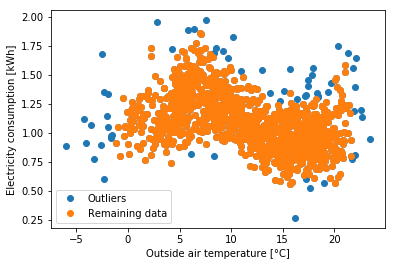

In [5]:
ES.plot()
_=ES.outlier_detection(n_days=25, contamination=.05)
ES.plot()
plt.legend(['Outliers', 'Remaining data'])

# Fitting a model
With multiple linear regression and support vector regression two options for model fitting are part of the energy signature class and introduced below. Both are wrapper function around established, and well-tested existing software packages. [[1]] [[2]]

In case of multiple linear regression a Bayesion Optimisation is conducted to find the optimila choice of number of segments. The optimization has to be calibrated by penalizing the use of high numbers of segements (parameter $l$).

In case of SVR, we implemented a simple grid search and cross-validation to pick the regularization parameter $\gamma$.

[1]: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
[2]: https://github.com/cjekel/piecewise_linear_fit_py


 
 Opt found 

Optimum number of line segments: [4.]
Function value: 33.382277580274774


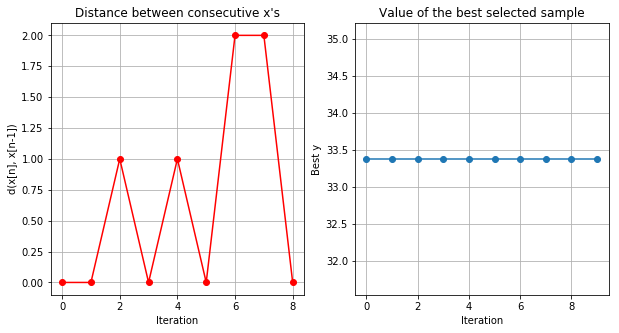

In [6]:
_=ES.multiple_linear_regression(plot=True)

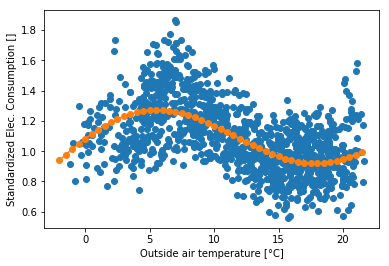

In [7]:
_ = ES.svr_fit(plot=True)

# Physical properties of the building:

## Balance-point, max heating rate, max cooling rate

We use the multiple linear regression to determine balance-point, heating rate and cooling rate of a building. Balance-point is defined as the point where the slope in the ES model changes from heating/no-heating to cooling/no-cooling. Heating rate is defined as the largest slope if the building is heating (minmum slope of all segments), colling rate is defined as the largest slope if the building is cooling (maximum slope of all segments).

In [8]:
ES.physical_properties(metrics=['bp','cr','hr'])


 
 Opt found 

Optimum number of line segments: [4.]
Function value: 33.382277580274774
[-1.20416667  3.75416666  6.47073609 14.68005761 21.6125    ]
Balance point is: 14.680057612664354
Cooling rate is: 0.01742442331754795
Heating rate is: -0.0605514922619438


# Normalization of Energy Signature
Normalization is essential if multiple energy signature are to compared to each other. Different options of normalization are considered.

## (a) Z-score normalization

In [9]:
_=ES.normalize()
_=ES.svr_fit(plot=True)

## (b) Base-load normalization
In this normalization scheme we determine the base-load of the building using piecewise linear-regression. After that we devide all daily recordings by the base load value.


 
 Opt found 

Optimum number of line segments: [4.]
Function value: 25.85645869907342


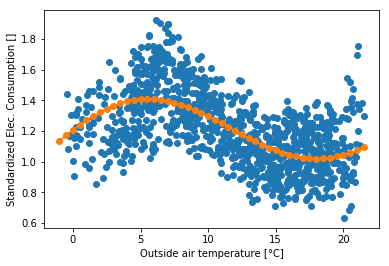

In [10]:
ES = enerSign(df_use = df.energy_kWh, df_temperature=df_wthr.temperature)
_=ES.outlier_detection(n_days=20, contamination=.1)
_=ES.normalize(normalizer='ES_norm_I')
_=ES.svr_fit(plot=True)